In [1]:
import xgboost
import shap
import matplotlib.pylab as pl
import matplotlib

matplotlib.rcParams['font.family'] = 'Times New Roman'
pl.rcParams['font.weight'] = 'bold'  
pl.rcParams['axes.labelweight'] = 'bold'  
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
path = '/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/30'

if not path.endswith('/'):
    path += '/'
if not os.path.isdir(path):
    os.mkdir(path)
C_file = open(path + 'score.txt', 'w')

In [3]:
X = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/reafter30.xlsx')
y = X['30_days_label']

drop_list = ['30_days_label']
X = X.drop(drop_list, axis=1)

fea_list = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/feature_list_reafter30.xlsx')
nominal_fea = fea_list[fea_list['Nominal']==1]['Type_Short_Name'].tolist()
nominal_fea = list(set(nominal_fea) & set(X.columns))
X = pd.get_dummies(X, columns=nominal_fea, drop_first=True)

print(X.columns)

Index(['MIC: IMP or MPM', 'WBC, Low', 'PLT, High', 'MPV', 'PT', 'aPTT', 'ALP',
       'Total Cheloesterol', 'K, Low', 'cl, Low', 'protein',
       'colonization_sputum_1'],
      dtype='object')


In [4]:
print(X.columns)
print(X.shape)
print('# samples: ', X.shape[0])
print('# positive samples: ', sum(y==1))
print('# negative samples: ', sum(y==0))
print('# features: ', X.shape[1])
print('# samples: ', X.shape[0], file=C_file)
print('# positive samples: ', sum(y==1), file=C_file)
print('# negative samples: ', sum(y==0), file=C_file)
print('# features: ', X.shape[1], file=C_file)

Index(['MIC: IMP or MPM', 'WBC, Low', 'PLT, High', 'MPV', 'PT', 'aPTT', 'ALP',
       'Total Cheloesterol', 'K, Low', 'cl, Low', 'protein',
       'colonization_sputum_1'],
      dtype='object')
(639, 12)
# samples:  639
# positive samples:  72
# negative samples:  567
# features:  12


# create a train/val/test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [6]:
print('start training XGBoost')

start training XGBoost


### Train Model ###

In [7]:
other_params = {'colsample_bylevel': 1, 'colsample_bytree': 1, 'learning_rate': 0.03, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.5, 'objective':'binary:logistic', 'gamma': 0, 'random_state': 7}
xlf = xgboost.XGBClassifier(**other_params)
xlf.fit(X_train, y_train)
model_train = xlf
pickle.dump(model_train, open(path + "model.pickle.dat", "wb"))

### Evaluate Model ###

In [8]:
auc = roc_auc_score(y_test, model_train.predict_proba(X_test)[:, 1])
AP = average_precision_score(y_test, model_train.predict_proba(X_test)[:, 1])
print("ROC_AUC Score: {}".format(auc))
print("AP value: {}".format(AP))

ROC_AUC Score: 0.8449494949494949
AP value: 0.6512362918676736


In [9]:
X_test = X_test.astype({col: int for col in X_test.select_dtypes(include=bool).columns})
X_train = X_train.astype({col: int for col in X_train.select_dtypes(include=bool).columns})

In [10]:
C_file.write('ROC_AUC Score: '+str(auc)+'\n')
C_file.write('AP value: '+str(AP)+'\n')

C_file.close()

In [11]:
print('start training TreeExplainer')
back_data = X_train
fore_data = X_test
fore_data_label = pd.DataFrame(y_test)

start training TreeExplainer


In [12]:
fore_data.to_excel(path + 'fore_data.xlsx', index = False)
fore_data_label.to_excel(path + 'fore_data_label.xlsx', index = False)

In [13]:
explainer = shap.TreeExplainer(model_train, data=back_data)
shap_values = explainer.shap_values(fore_data, check_additivity=False)
display_name = pd.read_excel('/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/reafter30/feature_list_Display_name after30.xlsx')
display_col = []
for col in fore_data.columns:
    display_col.append(list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0])
col_dict = dict(zip(fore_data.columns, display_col))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kj/Library/CloudStorage/OneDrive-한림대학교/연구 및 과제/박사논문/reafter30/feature_list_Display_name after30.xlsx'

In [57]:
np.save(path + 'shap_values.npy', shap_values)

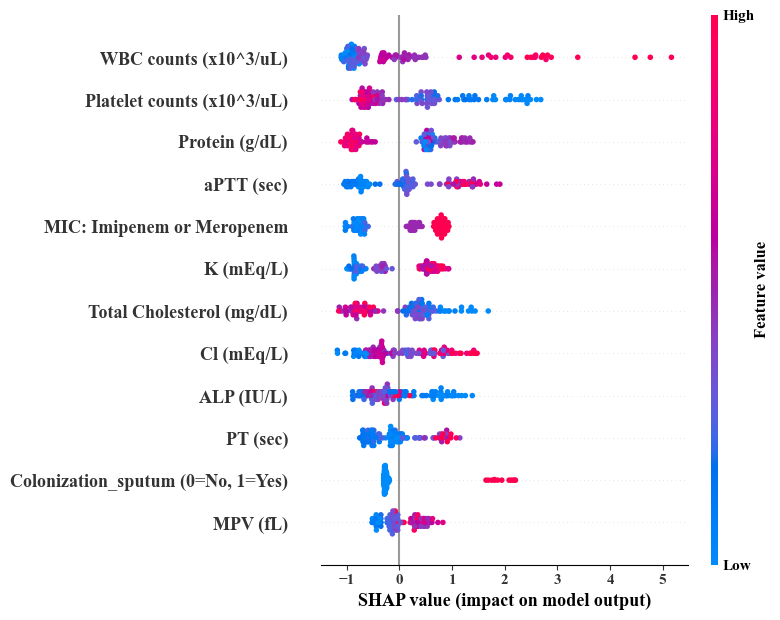

start calculating SHAP interaction values


In [58]:
fore_data = fore_data.rename(columns=col_dict)
shap.summary_plot(shap_values, fore_data, max_display=12, show=False)
# 현재 그림을 TIFF 파일로 저장
pl.savefig(path + 'shap summary plot.tiff', format='tiff', dpi=300)
pl.show()

print('start calculating SHAP interaction values')

In [35]:
shap_inter_values = shap.TreeExplainer(model_train, data=back_data, feature_perturbation='tree_path_dependent').shap_interaction_values(fore_data)
np.save(path + 'shap_interaction_values.npy', shap_inter_values)

In [36]:
import numpy as np
import pandas as pd

shap_values = np.load(path + 'shap_values.npy')

shap_abs_mean = np.abs(shap_values).mean(axis=0)

shap_ranking = pd.DataFrame(shap_abs_mean, index=fore_data.columns, columns=['SHAP Abs Mean'])

shap_ranking_sorted = shap_ranking.sort_values(by='SHAP Abs Mean', ascending=False)

# 랭킹 출력
shap_ranking_sorted.to_excel(path + 'shap_ranking.xlsx')

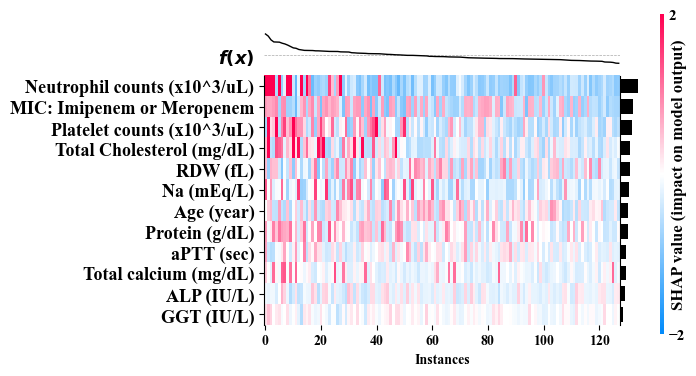

In [58]:

explainer = shap.TreeExplainer(model_train, data=back_data)


shap_values = explainer(fore_data)
pl.figure(figsize=(15, 21)) 
pl.subplots_adjust(left=0.4, right=0.9)  
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), max_display=12, show=False)


pl.savefig(path + 'shap Hitmap.tiff', format='tiff', dpi=300)
pl.show()

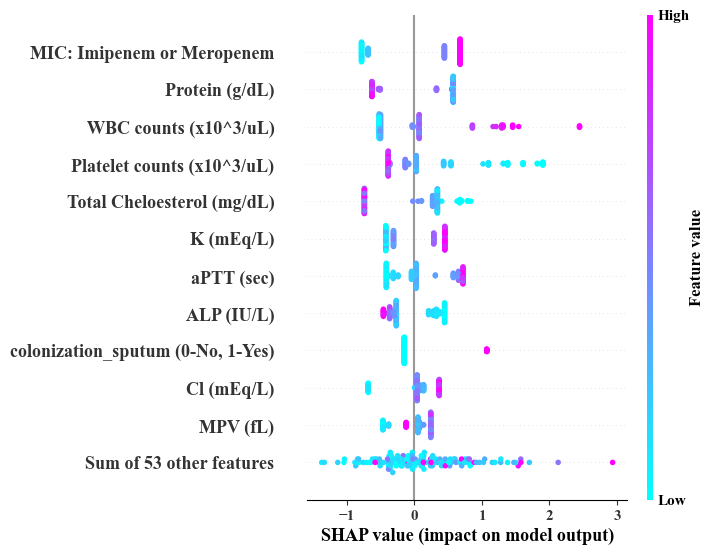

In [17]:

explainer = shap.TreeExplainer(model_train, data=back_data)


shap_values = explainer(fore_data)

pl.subplots_adjust(left=0.4, right=0.9) 
shap.plots.beeswarm(shap_values, color=pl.get_cmap("cool"), max_display=12, show=False)


pl.savefig(path + 'shap cool.tiff', format='tiff', dpi=300)
pl.show()

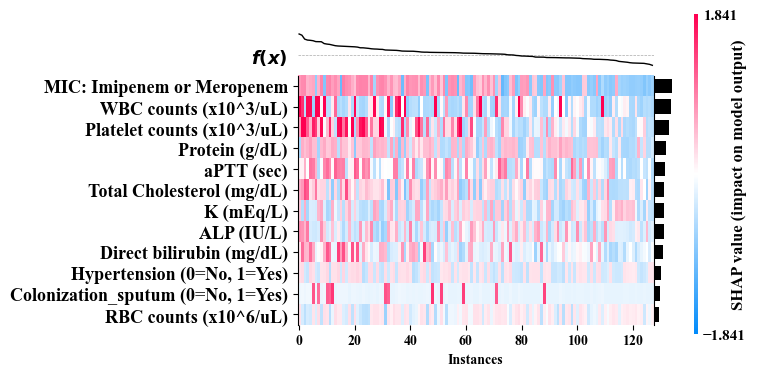

In [39]:

explainer = shap.TreeExplainer(model_train, data=back_data)


shap_values = explainer(fore_data)


pl.figure(figsize=(20, 20))


pl.subplots_adjust(left=0.4, right=0.9, top=0.95, bottom=0.05)


shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), max_display=12, show=False)


pl.savefig(path + 'shap Heatmap.tiff', format='tiff', dpi=300)
pl.show()

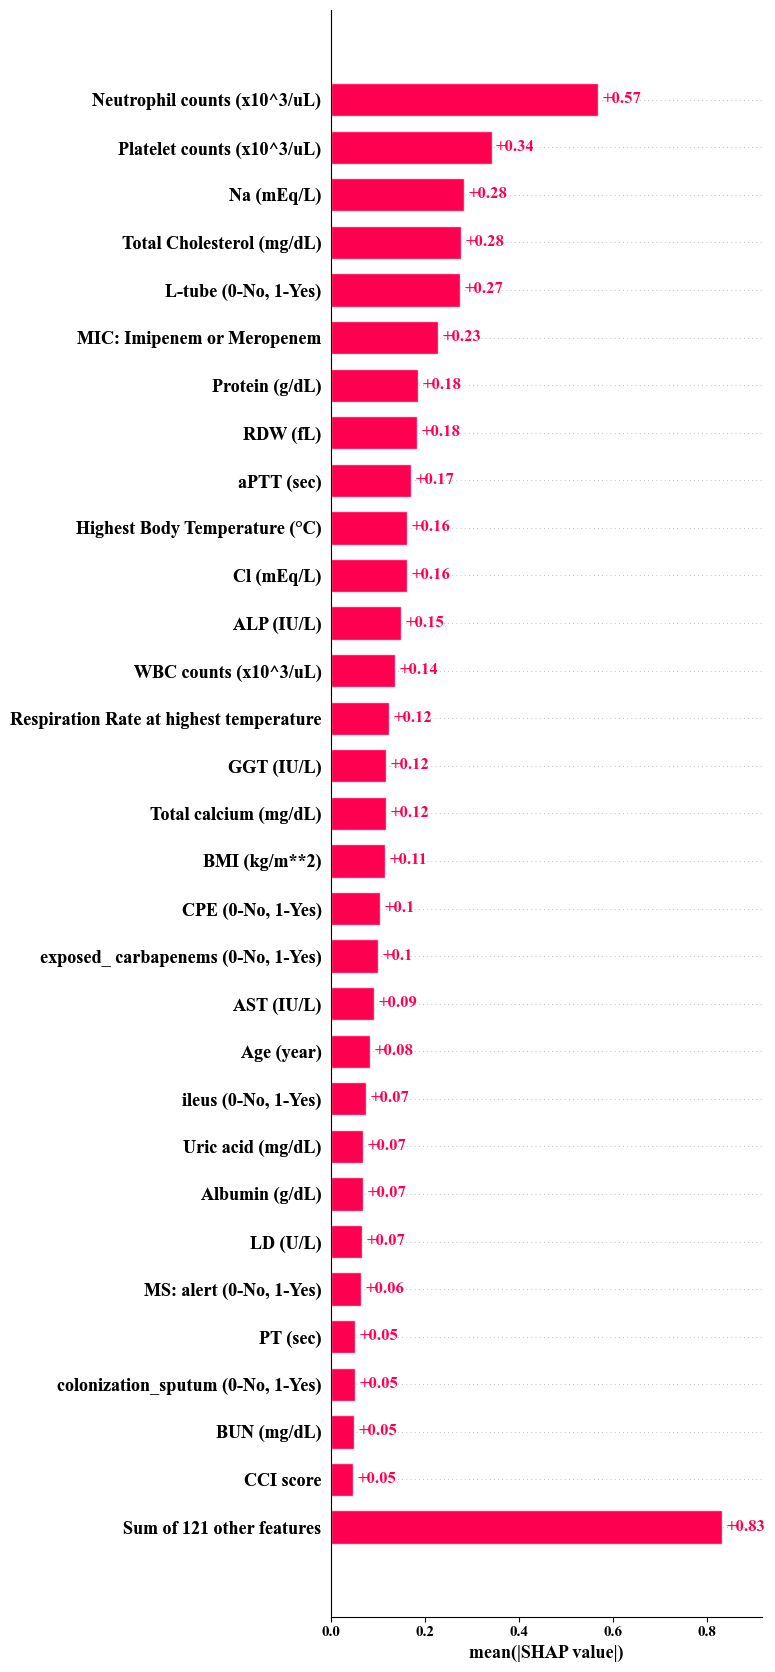

In [58]:

explainer = shap.TreeExplainer(model_train, data=back_data)

shap_values = explainer(fore_data)


pl.rcParams.update({'font.size': 16}) 

shap.plots.bar(shap_values, max_display=31, show=False)


pl.tight_layout()

pl.savefig(path + 'shap bar plot.tiff', format='tiff', dpi=300)
pl.show()

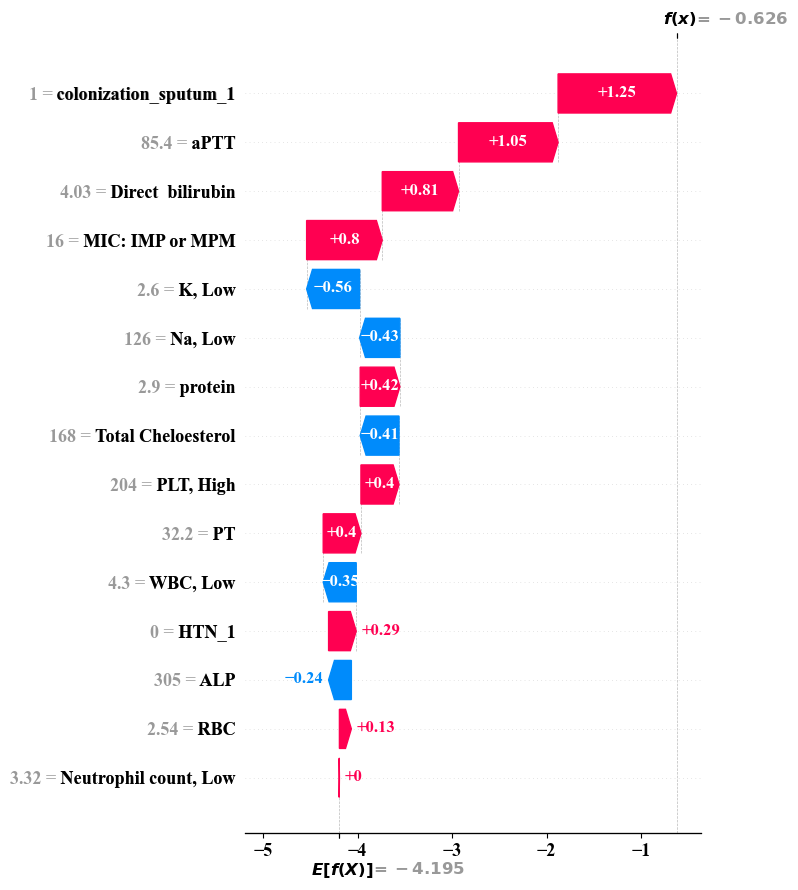

In [45]:

explainer = shap.TreeExplainer(model_train, data=back_data)

shap_values = explainer(fore_data)

shap.plots.waterfall(shap_values[70], max_display=15, show=False)

pl.tight_layout()

pl.savefig(path + 'shap waterfall.tiff', format='tiff', dpi=300)
pl.show()

In [40]:

import matplotlib.pyplot as plt


explainer = shap.TreeExplainer(model_train, data=back_data)


expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[23]  # 분류 문제의 경우 긍정 클래스에 대한 기대값 사용
print(f"Explainer expected value: {expected_value}")


shap_values = explainer.shap_values(fore_data)


plt.figure(figsize=(12, 14))
shap.decision_plot(expected_value, shap_values[select], fore_data.iloc[select], feature_names=display_col)


plt.savefig(path + 'dicisionplot.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()


Explainer expected value: -4.119597420642362


NameError: name 'select' is not defined

<Figure size 1200x1400 with 0 Axes>

In [41]:
y_pred = model.predict(X_test)   # Get predictions on the probability scale.
T = X_test[(y_pred >= 0.03) & (y_pred <= 0.1)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[1]
r = shap.decision_plot(
    expected_value, sh, T, feature_order="hclust", return_objects=True
)

NameError: name 'model' is not defined